# <font color=blue> Text Classification using Recurrent Neural Networks (RNN) with PyTorch </font>
**Author:**  Armin Berger

For this project we seek to classify the topic of scientific journal abstracts (supervised learning). The possible topics for each abstract are Information Theory, Computer Vision, and Mathamatics. These three classes can only take Boolean values, ‘1’ if it is classified as the topic and ‘0’ if not. Thus, we will create separate models for each of the three classes.

To correctly classify the abstracts, we need to follow a series of steps.

#### 1. Configure a Text Pre-Processer for our abstracts
In order to classify text, we need to break down each abstract into tokens and pre-process the token. This will be done using two different configurations.

* Wordnet Lemmatizer NLTK: This lemmatizier splits text into its individual tokens and converts them into their base form. We remove all words with less than 2 characters. Then all words will be converted to lower case. Remove all context independent and dependent stop words.
* SpaCy Tokenizer & Stemmer: This lemmatizier splits text into its individual tokens and converts them into their base form. We remove all words with less than 3 characters. Remove all context independent and dependent stop words.

#### 2. Configure the Text Vectorizer
Since our model input is natural language, we need to find a way to quantify it. A common solution for this problem is the use of a TF-IDF Vectorizer, which turns words of each document into a vector. We will use the TfidfVectorizerConvert from the sklearn package. The pre- processing configuration above will be the parameters of TfidfVectorizerConvert().

#### 3. Train classification models
To classify our abstracts, we will use two models, logistic regression and recurrent neural network (RNN). For both models, we need to take the following steps:

* Logistic Regression: Firstly, we need to transform both the inputs and outputs into a form that sklearn can use to fit a logistic regression to them.
* RNN: For this model, we will have to transform both the inputs and outputs as well. We will use Pytorchs RNN class that was used in tutorial week 4.

#### 4. Evaluation of model performance
After training a predictive model we need to assess the quality of its predictions. In the classification setting, we commonly use matrices such as accuracy, precession & recall and F1 scores. I visualise the performance of the classification models above using precision-recall curve, which plots recall against precision on an x-y plane.

#### Structure of a Recurrent Neural Network

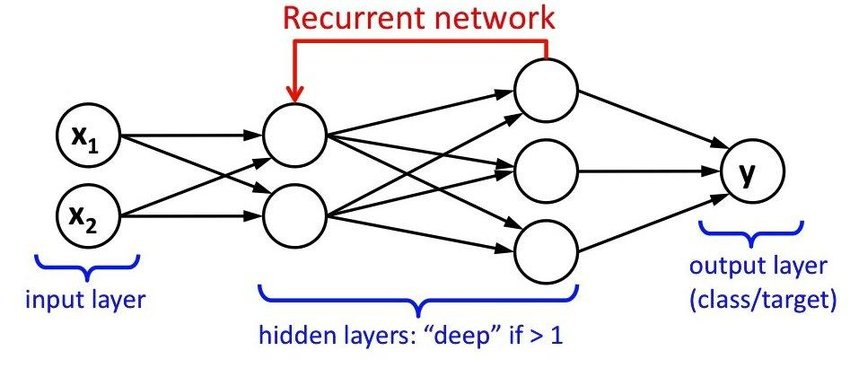

In [7]:
from IPython.display import Image
Image(filename='rnn.png') 

In [2]:
# install all required packages 

#!pip install pandas
#!pip install matplotlib
#!pip install scikit-learn
#!pip install nltk
#!pip install seaborn
#!pip install ggplot
#!pip3 install torchtext
#!pip3 install torch
#!pip3 install spacy

In [1]:
# import all required packages 

import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as matplot
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize    
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB,BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve
import seaborn as sns
import re
import os, sys
import torch
import torch.nn as nn
from torchtext.legacy import data
from torchtext.legacy.data import TabularDataset
import torch.optim as optim
import time
import spacy
from spacy.lang.en import English

nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/arminberger/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/arminberger/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# <font color=blue> Text Classification </font>

#### Overview
For this project we seek to classify the topic of scientific journal abstracts (supervised learning). The possible topics for each abstract are InfoTheory, CompVis, and Math. These three classes can only take Boolean values, ‘1’ if it is classified as the topic and ‘0’ if not. Thus, we will create separate models for each of the three classes.

Specifically the two models that we will comapre are the Logistic Regression and and a recurrent neural network (RNN). Both models will be trained and evaluated using the same data set. After training them we will compare their performance, visualize it, and analyse their differences.

### Data preperation - Reading in data & Basic Data Exploration

Before we can train and test a model we need data. We will read in the training and testing data in csv format and check for any anomalies as well as the distribution of the labels amongst the three classes InfoTheory, CompVis, and Math.

In [4]:
# read in data via google drive

#root_path = 'drive/MyDrive/' # path used for my machine during training 

root_path = os.getcwd() + '/' # path of actual current directory

root_path

'drive/MyDrive/'

In [5]:
# read in data from csv file using the current root path

# training data
train = pd.read_csv(root_path + 'axcs_train.csv')

# testing data
test = pd.read_csv(root_path + 'axcs_test.csv')

Since the data is already split in a train and test set we we don't need to manulally do that.

In [6]:
# get first view
train.head()

,ID,URL,Date,Title,InfoTheory,CompVis,Math,Abstract
0,cs-9301111,arxiv.org/abs/cs/9301111,1989-12-31,Nested satisfiability,0,0,0,Nested satisfiability A special case of the s...
1,cs-9301112,arxiv.org/abs/cs/9301112,1990-03-31,A note on digitized angles,0,0,0,A note on digitized angles We study the confi...
2,cs-9301113,arxiv.org/abs/cs/9301113,1991-07-31,Textbook examples of recursion,0,0,0,Textbook examples of recursion We discuss pro...
3,cs-9301114,arxiv.org/abs/cs/9301114,1991-10-31,Theory and practice,0,0,0,Theory and practice The author argues to Sili...
4,cs-9301115,arxiv.org/abs/cs/9301115,1991-11-30,Context-free multilanguages,0,0,0,Context-free multilanguages This article is a...


In [7]:
train.columns

Index(['ID', 'URL', 'Date', 'Title', 'InfoTheory', 'CompVis', 'Math',
       'Abstract'],
      dtype='object')

Our data set contains 8 features ('ID', 'URL', 'Date', 'Title', 'InfoTheory', 'CompVis', 'Math', 'Abstract') of which we will only use 'InfoTheory', 'CompVis', 'Math', 'Abstract' in this project.

For both models, the logistic regression and the RNN, 'InfoTheory', 'CompVis', and 'Math' will be our target features, while 'Abstract' is our predictor feature. Which means we will use 'Abstract' to predict 'InfoTheory', 'CompVis', and 'Math'. 

In [8]:
# get idea of dimensions of data
print(train.shape)
print(test.shape)

(54731, 8)
(19678, 8)


We see that our training data conatains 54731 observations which are plenty to train a model on.

In [9]:
# get more information on all the columns

print('#### train ####')

print(train.info())

print('#### test ####')

print(test.info())

#### train ####
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54731 entries, 0 to 54730
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          54731 non-null  object
 1   URL         54731 non-null  object
 2   Date        54731 non-null  object
 3   Title       54731 non-null  object
 4   InfoTheory  54731 non-null  int64 
 5   CompVis     54731 non-null  int64 
 6   Math        54731 non-null  int64 
 7   Abstract    54731 non-null  object
dtypes: int64(3), object(5)
memory usage: 3.3+ MB
None
#### test ####
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19678 entries, 0 to 19677
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          19678 non-null  object
 1   URL         19678 non-null  object
 2   Date        19678 non-null  object
 3   Title       19678 non-null  object
 4   InfoTheory  19678 non-null  int64 
 5   CompVis     1

After reading in the data we will do some basic wrangling steps, such as checking for missing values, duplicate ids and general inconsistencies. 

In [10]:
# check if ID is unique

print('#### train ####')

print(train['ID'].describe())

print('#### test ####')

print(test['ID'].describe())


#### train ####
count           54731
unique          54731
top       no-13035365
freq                1
Name: ID, dtype: object
#### test ####
count            19678
unique           19678
top       no-151206235
freq                 1
Name: ID, dtype: object


All articles are unique and there are no duplicats in our data.

In [11]:
# check if columns InfoTheory, CompVis, Math only contain binary values

print('#### train ####')

print(train['InfoTheory'].value_counts())

print(train['CompVis'].value_counts())

print(train['Math'].value_counts())

print('#### test ####')

print(train['InfoTheory'].value_counts())

print(train['CompVis'].value_counts())

print(train['Math'].value_counts())

#### train ####
0    44193
1    10538
Name: InfoTheory, dtype: int64
0    52507
1     2224
Name: CompVis, dtype: int64
0    38004
1    16727
Name: Math, dtype: int64
#### test ####
0    44193
1    10538
Name: InfoTheory, dtype: int64
0    52507
1     2224
Name: CompVis, dtype: int64
0    38004
1    16727
Name: Math, dtype: int64


The target features InfoTheory, CompVis, Math only contained binary values (0/1).

In [12]:
# check if all Abstracts are unique

print('#### train ####')

print(train['Abstract'].describe())

print('#### test ####')

print(test['Abstract'].describe())

#### train ####
count                                                 54731
unique                                                54700
top        Discussion: Latent variable graphical model s...
freq                                                      4
Name: Abstract, dtype: object
#### test ####
count                                                 19678
unique                                                19677
top        Incorporating Both Distributional and Relatio...
freq                                                      2
Name: Abstract, dtype: object


Some abstracts are the same despite having different ID values. We will now assess whether the same abstract was assigned to topics differently. 

### Data distribution - Check for the distribution of the different classes

Since there are three classes and any cobination is possible we have a total of eight possible classes in the data. We will check their distribution and plot it.

In [13]:
# get all possible combinations
OOO = (train['InfoTheory'] == 0) & (train['CompVis'] == 0) & (train['Math'] == 0)
OOI = (train['InfoTheory'] == 0) & (train['CompVis'] == 0) & (train['Math'] == 1)
OII = (train['InfoTheory'] == 0) & (train['CompVis'] == 1) & (train['Math'] == 1)
IOI = (train['InfoTheory'] == 1) & (train['CompVis'] == 0) & (train['Math'] == 1)
IIO = (train['InfoTheory'] == 1) & (train['CompVis'] == 1) & (train['Math'] == 0)
IOO = (train['InfoTheory'] == 1) & (train['CompVis'] == 0) & (train['Math'] == 0)
OIO = (train['InfoTheory'] == 0) & (train['CompVis'] == 1) & (train['Math'] == 0)
III = (train['InfoTheory'] == 1) & (train['CompVis'] == 1) & (train['Math'] == 1)

In [14]:
# create dict to save data in
data_distribution = dict()

# create pd to save dict data in
data_distribution_df = pd.DataFrame()

# save the number of rows for each class in the dict data_distribution
data_distribution["OOO"] = train.loc[OOO].shape[0]
data_distribution["OOI"] = train.loc[OOI].shape[0]
data_distribution["OII"] = train.loc[OII].shape[0]
data_distribution["IOI"] = train.loc[IOI].shape[0]
data_distribution["IIO"] = train.loc[IIO].shape[0]
data_distribution["IOO"] = train.loc[IOO].shape[0]
data_distribution["OIO"] = train.loc[OIO].shape[0]
data_distribution["III"] = train.loc[III].shape[0]


In [15]:
# turn dict data into pandas dataframe
data_distribution_df = pd.DataFrame(index = range(1) , data = data_distribution)

Text(0.5, 1.0, 'Distribution of text categories')

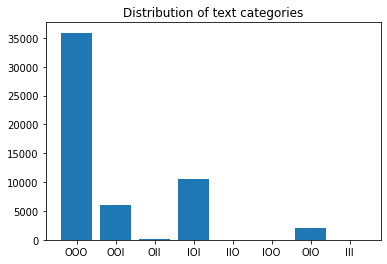

In [16]:
# use matplot lib to visualize the results
matplot.bar(x = data_distribution_df.columns.tolist() , height = data_distribution_df.iloc[0].tolist())
matplot.title('Distribution of text categories')

In [17]:
# double checking if for these classes the observation count is actually zero.
print(data_distribution["IOO"])
print(data_distribution["IIO"])
print(data_distribution["III"])

0
0
0


The distribution of our classes shows that the dataset is sevierly imbalanced.
Most of the abstract belong to no class (000), while the second most articles belong to both InfoTheory and Math.
There are no articles that belong to only InfoTheory (100). This means that our model will have a hard time classifying abstracts as InfoTheory, since it has little to no observations to train on.

## Part 1A: Statistical Method

For the first part of the project we will use Logistic Regression to predict the binary lable values of our abstracts. 

Step 1 - In the first step we preprocess our model's inputs and define methods that will be needed for training and evalualtion of our model. 

In [18]:
## STEP 1A - GET SHORT & FULL VERSION OF DATA SETS

# we want the training and testing data set in two configurations 
# the first 1,000 observations and all observations

train_short = train.loc[0:999,]

train_long = train

In [19]:
## STEP 1B - TRANSFORM THE TRAIN DATA for first 1,000 obseravtions (short)

# turn the text inputs of our model into lists
train_predictor_short = train_short.Abstract.tolist()

# turn the target lables of our model into lists and then into numpy arrays 
# this is required since libraries such as scikit-learn require it as tarining inputs
train_lable_InfoTheory_short = np.array(train_short.InfoTheory.tolist())

train_lable_CompVis_short = np.array(train_short.CompVis.tolist())

train_lable_Math_short = np.array(train_short.Math.tolist())


In [20]:
## STEP 1B - TRANSFORM THE TRAIN DATA for all obseravtions (long)

# turn the text inputs of our model into lists
train_predictor_long = train_long.Abstract.tolist()

# turn the target lables of our model into lists and then into numpy arrays 
# this is required since scikit-learn only works with lables in np.array() format
train_lable_InfoTheory_long = np.array(train_long.InfoTheory.tolist())

train_lable_CompVis_long = np.array(train_long.CompVis.tolist())

train_lable_Math_long = np.array(train_long.Math.tolist())


In [21]:
## STEP 1B - TRANSFORM THE TEST DATA 

# turn the text inputs of our model into lists
test_predictor = test.Abstract.tolist()

# turn the target lables of our model into lists and then into numpy arrays 
# this is required since scikit-learn only works with lables in np.array() format
test_lable_InfoTheory = np.array(test.InfoTheory.tolist())

test_lable_CompVis = np.array(test.CompVis.tolist())

test_lable_Math = np.array(test.Math.tolist())

In [22]:
## STEP 1C - DEFINE OUR TOKENIZER NUMBER 1

# this is the NLTK_LemmaTokenizer used to transform the input text
# into indiviual tokens

class NLTK_LemmaTokenizer(object):
    
    def __init__(self):
        
        self.wnl = WordNetLemmatizer()
        
    def __call__(self,doc):
        
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [23]:
## STEP 1C - DEFINE OUR TOKENIZER NUMBER 2

# this is the SnowballStemmerTokenizer used to transform the input text
# into indiviual tokens
    
class SnowballStemmerTokenizer(object):
    
    def __init__(self):
        
        self.ps = SnowballStemmer('english')
        
    def __call__(self,doc):
        
        return [self.ps.stem(t) for t in word_tokenize(doc)]

In [24]:
## STEP 1D - CREATE WORD EMBEDINGS: NUMBER 1

# TfidfVectorizer is a vectorizer in sklearn which turns a collection
# of raw documents to a matrix of TF-IDF features

vectorizer_01 = TfidfVectorizer(analyzer = 'word',
                             input = 'content',
                            lowercase = True,
                           token_pattern = '(?u)\\b\\w\\w+\\b',
                           min_df = 3,
                           ngram_range = (1,2),
                           tokenizer = NLTK_LemmaTokenizer())


In [25]:
## STEP 1D - CREATE WORD EMBEDINGS: NUMBER 2

# TfidfVectorizer is a vectorizer in sklearn which turns a collection
# of raw documents to a matrix of TF-IDF features

vectorizer_02 = TfidfVectorizer(analyzer = 'word',
                             input = 'content',
                            lowercase = True,
                           token_pattern = '(?u)\\b\\w\\w+\\b',
                           min_df = 3,
                           ngram_range = (1,2),
                           tokenizer = SnowballStemmerTokenizer())

Step 2 - In the second step we save the processed model in and outputs. Specfically we quantify the input tokens using the TfidfVectorizer (word embedings). 

In [26]:
## Step 2A - DEFINE ALL NECESSARY VARIABLES NEEDED FOR TRAINING THE MODEL

# statistical model used in this assignement
model = LogisticRegression()

# train text inputs for LogisticRegression
x_train_list = [train_predictor_short, train_predictor_long]

# train label inputs for LogisticRegression
y_train_list = [train_lable_InfoTheory_short, train_lable_CompVis_short, 
                train_lable_Math_short, train_lable_InfoTheory_long,
                train_lable_CompVis_long, train_lable_Math_long]

# test label inputs for LogisticRegression
y_test_list = [test_lable_InfoTheory, test_lable_CompVis, test_lable_Math, 
              test_lable_InfoTheory, test_lable_CompVis, test_lable_Math]

# list of our two vectorizers 
vec_list = [vectorizer_01, vectorizer_02]

# name of the model
name = 'Log. Regression'

# list of labels used
label = ['InfoTheory', 'CompVis', 'Math','InfoTheory', 'CompVis', 'Math']

# list of name of our two vectorizers 
vec_label = ['vec_01', 'vec_02']

In [27]:
## Step 2A - VECTORIZE THE TEXT INPUT AND SAVE IT TO LIST

# list that saves our vectorized text input
x_train_vec_list = []

# iterate through two different training data lenghts (short/long)
for t in range(0,2):

    # iterate through two different vectorizer options
    for n in range(0,2):
        
        # vectorize the training text input (for different variants)
        x_train = vec_list[n].fit_transform(x_train_list[t])

        # vectorize the test text input
        x_test = vec_list[n].transform(test_predictor)

        # append vectorized output to list
        x_train_vec_list.append((x_train, x_test))
    

In [28]:
# create dataframe to store model results
model_perfromance_df = pd.DataFrame( columns=['Model_Name', 'Label', 'Tokenizer',
                                              'Lenght', 'Accuracy', 'Macro_Precision',
                                              'Macro_Recall', 'Macro_F1_score']) #, 'MCC'])
# check new dataframe
model_perfromance_df

,Model_Name,Label,Tokenizer,Lenght,Accuracy,Macro_Precision,Macro_Recall,Macro_F1_score


Step 3 - In the third step we train the model, assess its performance and save the results. 

In our data we have three different boolean targets ('InfoTheory', 'CompVis', and 'Math'), thus we will create three different models with three different model targets. Moreover, we have two different ways of tokenizing our abstract input. Lastly, we have the requirement of training the model on both the first 1,000 observations and all obseravtions.

Overall this means that we have to train 12 different logistic regressions models. After training each model we assess its performance and save that in the dataframe model_perfromance_df.

In [29]:
## Step 3A - TRAIN THE LOGISTIC REGRESSION MODEL

# set dict to save precision_recall_curve for model evalusation
prec_recall_dict = {}

# set count
count = 0

# iterate through the three different classifcation labels
for i in range(0,6):
    
    for t in range(0,2):
        
        # set of if statements to extract the correct vectorized model
        # input that was trained before, as well as save the lenght of training
        # data used for each iteration
        if i < 3 and t == 0:
            
            x_input = 0
            length = 'short'
            
        elif i < 3 and t == 1:
            
            x_input = 1
            length = 'short'
        
        elif i > 2 and t == 0:
            
            x_input = 2
            length = 'long'
        
        elif i > 2 and t == 1:
            
            x_input = 3
            length = 'long'
        
        # set vectorized x input
        x_train = x_train_vec_list[x_input][0]
        
        # set vectorized x input
        x_test = x_train_vec_list[x_input][1]

        # fit the LogisticRegression using our training data
        model = model.fit(x_train , y_train_list[i])

        # prediction of our target
        y_predict = model.predict(x_test)
        
        
        ## Calculate performance indicators

        # create and save precision_recall_curve for model evalusation
        prec_recall_dict[count] = [precision_recall_curve(y_test_list[i], y_predict)]
        
        accuracy = accuracy_score(y_test_list[i], y_predict)

        precision = precision_score(y_test_list[i], y_predict,average = 'macro')

        recall = recall_score(y_test_list[i], y_predict,average = 'macro')

        f1score = f1_score(y_test_list[i], y_predict,average = 'macro')

        #matthews = matthews_corrcoef(y_test_list[i],y_predict)
        
        model_name = name

        label_mod = label[i]

        vec = str(vec_label[t]) 
        
        # save all indicators in list logistic_row
        logistic_row = [model_name, label_mod, vec, length, accuracy, precision, recall, f1score]#, matthews]

        # append list to dataframe
        model_perfromance_df.loc[count,:] = logistic_row
        
        # increment count
        count += 1



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Pr

In [30]:
# All linear regressions so far 
model_perfromance_df

,Model_Name,Label,Tokenizer,Lenght,Accuracy,Macro_Precision,Macro_Recall,Macro_F1_score
0,Log. Regression,InfoTheory,vec_01,short,0.816241,0.408121,0.5,0.449412
1,Log. Regression,InfoTheory,vec_02,short,0.816241,0.408121,0.5,0.449412
2,Log. Regression,CompVis,vec_01,short,0.890639,0.44532,0.5,0.471078
3,Log. Regression,CompVis,vec_02,short,0.890639,0.44532,0.5,0.471078
4,Log. Regression,Math,vec_01,short,0.698648,0.349324,0.5,0.411297
5,Log. Regression,Math,vec_02,short,0.698648,0.349324,0.5,0.411297
6,Log. Regression,InfoTheory,vec_01,long,0.947657,0.947042,0.874292,0.905258
7,Log. Regression,InfoTheory,vec_02,long,0.947606,0.946119,0.874904,0.905318
8,Log. Regression,CompVis,vec_01,long,0.951418,0.954097,0.789295,0.848533
9,Log. Regression,CompVis,vec_02,long,0.952587,0.955063,0.794638,0.85306


Now we have successfully trained and tested our statistical model, a Logistic Regression.

## Part 1B: RNN Method

Recurrent neural network (RNN) are commonly used for sequential data, since their output is reused as the models input. Thus a RNN is a great choice for text classifcation tasks since the sequential order of words contains a lot of meaning and should be capture in a classifcation setting.

The steps taken in training and deploying an RNN are not to different to deploying the earlier used Logistic Regression model.

In [31]:
## STEP 1A - GET SHORT & FULL VERSION OF DATA SETS

# we want the training/validation and testing data set in two configurations 
# the first 1,000 observations and all observations

# first 1,000 observations
train_1000 = train.loc[0:999,]

# all observations
train_full = train

In [32]:
## STEP 1B - WRITE DATA TO LOCAL DRIVE

# write the edited dataframe to a csv file
train_1000.to_csv(root_path+'train_1000.csv', index = False)

# write the edited dataframe to a csv file
train_full.to_csv(root_path+'train_full.csv', index = False)

In [33]:
## STEP 1C - DEFINE TOKENIZERS

# set up the two above created tokenizers
tokenizer_01 = NLTK_LemmaTokenizer()

tokenizer_02 = SnowballStemmerTokenizer()

In [34]:
## STEP 2A - DEFINE RNN MODEL - taken from tutorial week 4

# create the model class with all its methods
class RNN(nn.Module):
    
    # constructor method
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    # method to forward slope of error 
    def forward(self, text):
        
        embedded = self.embedding(text)
        
        output, hidden = self.rnn(embedded)
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        return self.fc(hidden.squeeze(0))

In [35]:
## STEP 2B - DEFINE BINARY ACCURACY METHODE FOR RNN - taken from tutorial week 4

# Returns accuracy per batch (if you get 8/10 right, this returns 0.8, NOT 8)
def binary_accuracy(preds, y):

    # round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))

    # convert into float for division
    correct = (rounded_preds == y).float()

    # calculate accuracy
    acc = correct.sum() / len(correct)
    
    return acc

In [36]:
## STEP 2C - DEFINE TRAINING METHODE FOR RNN - taken from tutorial week 4

# Training methode only for CompVis label

# method that trains the model, called every epoche
def train_c(model, iterator, optimizer, criterion):

    epochLoss = 0
    epochAccuracy = 0
    
    model.train()
    
    # iterate through each batch 
    for batch in iterator:
        
        # set optimizer to gradient zero
        optimizer.zero_grad()
        
        # predict target
        predictions = model(batch.Abstract).squeeze(1)
        
        # calculate loss 
        loss = criterion(predictions, batch.CompVis)
        accuracy = binary_accuracy(predictions, batch.CompVis)
        
        # use backpropogation to optimize 
        loss.backward()
        
        # use optimizer to move closer to the local optimum
        optimizer.step()

        epochLoss += loss.item()
            
        epochAccuracy += accuracy.item()


    return epochLoss/len(iterator), epochAccuracy/len(iterator)

In [37]:
## STEP 2C - DEFINE TRAINING METHODE FOR RNN - taken from tutorial week 4

# Training methode only for Math label

# method that trains the model
def train_m(model, iterator, optimizer, criterion):

    epochLoss = 0
    epochAccuracy = 0
    
    model.train()
    
    # iterate through each batch 
    for batch in iterator:
        
        # set optimizer to gradient zero
        optimizer.zero_grad()
        
        # predict target
        predictions = model(batch.Abstract).squeeze(1)
        
        # calculate loss 
        loss = criterion(predictions, batch.Math)
        accuracy = binary_accuracy(predictions, batch.Math)
        
        # use backpropogation to optimize 
        loss.backward()
        
        # use optimizer to move closer to the local optimum
        optimizer.step()

        epochLoss += loss.item()
            
        epochAccuracy += accuracy.item()


    return epochLoss/len(iterator), epochAccuracy/len(iterator)

In [38]:
## STEP 2C - DEFINE TRAINING METHODE FOR RNN - taken from tutorial week 4

# Training methode only for InfoTheory label

# method that trains the model
def train_i(model, iterator, optimizer, criterion):

    epochLoss = 0
    epochAccuracy = 0
    
    model.train()
    
    # iterate through each batch 
    for batch in iterator:
        
        # set optimizer to gradient zero
        optimizer.zero_grad()
        
        # predict target
        predictions = model(batch.Abstract).squeeze(1)
        
        # calculate loss 
        loss = criterion(predictions, batch.InfoTheory)
        accuracy = binary_accuracy(predictions, batch.InfoTheory)
        
        # use backpropogation to optimize 
        loss.backward()
        
        # use optimizer to move closer to the local optimum
        optimizer.step()

        epochLoss += loss.item()
            
        epochAccuracy += accuracy.item()


    return epochLoss/len(iterator), epochAccuracy/len(iterator)

In [39]:
## STEP 2D - DEFINE METHODE FOR RETURNING THE PREDICTED LABEL - taken from tutorial week 4

# return prediction methode only for CompVis label

def return_label_prediction_c(model, test_iterator, criterion):

    # list to save predicted target values
    y_predict = []

    # list to save actual target values
    y_test = []

    model.eval()

    with torch.no_grad():
        
        for batch in test_iterator:
            
            predictions = model(batch.Abstract).squeeze(1)
            
            rounded_preds = torch.round(torch.sigmoid(predictions))
            
            y_predict += rounded_preds.tolist()
            
            y_test += batch.CompVis.tolist()
        

    # save all target predictions as a numpy array
    rnn_y_predict = np.asarray(y_predict)

    # save all actual target values as a numpy array
    rnn_y_test = np.asarray(y_test)

    return rnn_y_predict, rnn_y_test

In [40]:
## STEP 2D - DEFINE METHODE FOR RETURNING THE PREDICTED LABEL - taken from tutorial week 4

# return prediction methode only for Math label

def return_label_prediction_m(model, test_iterator, criterion): 

    # list to save predicted target values
    y_predict = []

    # list to save actual target values
    y_test = []

    model.eval()

    with torch.no_grad():
        
        for batch in test_iterator:
            
            predictions = model(batch.Abstract).squeeze(1)
            
            rounded_preds = torch.round(torch.sigmoid(predictions))
            
            y_predict += rounded_preds.tolist()
            
            y_test += batch.Math.tolist()
        
        # save all the evaluation of the model

    # save all target predictions as a numpy array
    rnn_y_predict = np.asarray(y_predict)

    # save all actual target values as a numpy array
    rnn_y_test = np.asarray(y_test)

    return rnn_y_predict, rnn_y_test

In [41]:
## STEP 2D - DEFINE METHODE FOR RETURNING THE PREDICTED LABEL - taken from tutorial week 4

# return prediction methode only for InfoTheory label

def return_label_prediction_i(model, test_iterator, criterion): 
    
    # list to save predicted target values
    y_predict = []

    # list to save actual target values
    y_test = []

    model.eval()

    with torch.no_grad():
        
        for batch in test_iterator:
            
            predictions = model(batch.Abstract).squeeze(1)
            
            rounded_preds = torch.round(torch.sigmoid(predictions))
            
            y_predict += rounded_preds.tolist()
            
            y_test += batch.InfoTheory.tolist()
        
        # save all the evaluation of the model

    # save all target predictions as a numpy array
    rnn_y_predict = np.asarray(y_predict)

    # save all actual target values as a numpy array
    rnn_y_test = np.asarray(y_test)

    return rnn_y_predict, rnn_y_test

In [42]:
## STEP 2E - DEFINE METHODE FOR TUNING THE MODEL - taken from tutorial week 4

# evaluation function for tuning the model when training only for CompVis label

def evaluate_c(model, iterator, criterion): 
    
    epochLoss = 0 
    epochAccuracy = 0 

    # setting torch to evaluation mode 
    # only forward propagation needed 
    model.eval()
    
    # no paramter optimisation (backward propagation) needed 
    with torch.no_grad():

        for batch in iterator:

            predictions = model(batch.Abstract).squeeze(1)

            loss = criterion(predictions, batch.CompVis)
            
            accuracy = binary_accuracy(predictions, batch.CompVis)


            epochLoss += loss.item()
            
            epochAccuracy += accuracy.item()


    return epochLoss/len(iterator), epochAccuracy/len(iterator)

In [43]:
## STEP 2E - DEFINE METHODE FOR TUNING THE MODEL - taken from tutorial week 4

# evaluation function for tuning the model when training only for Math label

def evaluate_m(model, iterator, criterion): 
    
    epochLoss = 0 
    epochAccuracy = 0 

    # setting torch to evaluation mode 
    # only forward propagation needed 
    model.eval()
    
    # no paramter optimisation (backward propagation) needed 
    with torch.no_grad():

        for batch in iterator:

            predictions = model(batch.Abstract).squeeze(1)

            loss = criterion(predictions, batch.Math)
            
            accuracy = binary_accuracy(predictions, batch.Math)


            epochLoss += loss.item()
            
            epochAccuracy += accuracy.item()


    return epochLoss/len(iterator), epochAccuracy/len(iterator)

In [44]:
## STEP 2E - DEFINE METHODE FOR TUNING THE MODEL - taken from tutorial week 4

# evaluation function for tuning the model when training only for InfoTheory label

def evaluate_i(model, iterator, criterion): 
    
    epochLoss = 0 
    epochAccuracy = 0 

    # setting torch to evaluation mode 
    # only forward propagation needed 
    model.eval()
    
    # no paramter optimisation (backward propagation) needed 
    with torch.no_grad():

        for batch in iterator:

            predictions = model(batch.Abstract).squeeze(1)

            loss = criterion(predictions, batch.InfoTheory)
            
            accuracy = binary_accuracy(predictions, batch.InfoTheory)


            epochLoss += loss.item()
            
            epochAccuracy += accuracy.item()


    return epochLoss/len(iterator), epochAccuracy/len(iterator)

In [45]:
## STEP 2F - DEFINE METHODE FOR COMPARING TRAINING TIME - taken from tutorial week 4

def epoch_time(start_time, end_time):

    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))

    return elapsed_mins, elapsed_secs

Step 3 - In the third step we need to preporcess the training and testing data for our RNN Models.

In [46]:
## STEP 3A - SET FORMAT OF PREDICTOR AND TARGET

## First way of tokenizing

# input of our model, text data gets processed to make it useable
TEXT_01 = data.Field(sequential=True, tokenize = tokenizer_01 , lower=True)

## Second way of tokenizing

# input of our model, text data gets processed to make it useable
TEXT_02 = data.Field(sequential=True, tokenize = tokenizer_02 , lower=True)

# the models target, binary in this example (0/1)
LABEL = data.LabelField(dtype = torch.float, use_vocab=False, preprocessing=int)

In [47]:
## STEP 3B - CREATE LIST OF ALL POSSIBLE SCHEMA

# list that contains the three possible lables
LABEL_LIST = [(None, None, LABEL),(None, LABEL, None),(LABEL, None, None)]

# list that contains the two possible text tokenizations
TEXT_LIST = [TEXT_01, TEXT_02]

# list to save data field schemas
abstract_datafield_list = []

# iterate through all labels
for i in range(0,3):

    # iterate through two text tokenizations
    for t in range(0,2):

        # create data field schema
        abstract_datafield_list.append([('ID', None), ('URL', None), ('Date', None), ('Title', None),
        ('InfoTheory', LABEL_LIST[i][0]), ('CompVis', LABEL_LIST[i][1]), ('Math', LABEL_LIST[i][2]),
        ('Abstract', TEXT_LIST[t])])



In [48]:
## STEP 3C - PROCESSED/BATCH DATA INPUT - partially taken from tutorial week 4

# create dict to save all processed data by label 
train_data_dict = {'Math':[], 'CompVis':[], 'InfoTheory':[]}

# ensure that we can use the GPU for processing when possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# iterate throug the three different labels and two tokenizer options
# thus 6 iterations
for i in range(0,6):

    # Process the short data (1000 observations)

    # we save our read in data in three different data sets one for training and one for testing
    train_data_01, test_data = TabularDataset.splits(
        path = root_path, train = 'train_1000.csv', test = 'axcs_test.csv', format = 'csv', skip_header = True,
        fields = abstract_datafield_list[i])
    
    # split the training data into train and validate
    train_data_01, valid_data_01 = train_data_01.split()
    
    # now we split the input data into equally sized batches of size 16
    # this is required for training the RNN 
    train_iteration, valid_iteration, test_iteration = data.BucketIterator.splits((train_data_01, valid_data_01, test_data),\
                                            batch_size = 16,\
                                            device = device,\
                                            sort_key = lambda x: len(x.Abstract),\
                                            sort_within_batch = False)

    # determine which of the three labley the data processed belongs to
    # the append a tuple of length four that contains:
    # train_iteration = batched training input data
    # test_iteration = batched test input data
    # abstract_datafield_list[i][-1][1] = text field to build vocabulary for RNN
    # train_data_01 = unproccesd read in training input data

    if i < 2: 

        train_data_dict['Math'].append((train_iteration, test_iteration, valid_iteration, abstract_datafield_list[i][-1][1], train_data_01))

    elif i > 1 and i < 4: 

        train_data_dict['CompVis'].append((train_iteration, test_iteration, valid_iteration, abstract_datafield_list[i][-1][1], train_data_01))

    else: 

        train_data_dict['InfoTheory'].append((train_iteration, test_iteration, valid_iteration, abstract_datafield_list[i][-1][1], train_data_01))


    # Process the long data (all observations)

    # now we split the input data into equally sized batches of size 16
    # this is required for training the RNN 
    train_data_02 = TabularDataset.splits(
        path = root_path, train = 'train_full.csv',format = 'csv', skip_header = True,
        fields = abstract_datafield_list[i])[0]

    # split the training data into train and validate
    train_data_02, valid_data_02 = train_data_02.split()
    
    # now we split the input data into equally sized batches of size 16
    # this is required for training the RNN 
    train_iteration, valid_iteration, test_iteration = data.BucketIterator.splits((train_data_02, valid_data_02, test_data),\
                                            batch_size = 64,\
                                            device = device,\
                                            sort_key = lambda x: len(x.Abstract),\
                                            sort_within_batch = False)
    
    # determine which of the three labley the data processed belongs to
    # the append a tuple of length four that contains:
    # train_iteration = batched training input data
    # test_iteration = batched test input data
    # abstract_datafield_list[i][-1][1] = text field to build vocabulary for RNN
    # train_data_01 = unproccesd read in training input data

    if i < 2: 

        train_data_dict['Math'].append((train_iteration, test_iteration, valid_iteration, abstract_datafield_list[i][-1][1], train_data_02))

    elif i > 1 and i < 4: 

        train_data_dict['CompVis'].append((train_iteration, test_iteration, valid_iteration, abstract_datafield_list[i][-1][1], train_data_02))

    else: 
        
        train_data_dict['InfoTheory'].append((train_iteration, test_iteration, valid_iteration, abstract_datafield_list[i][-1][1], train_data_02))
        

Step 4 - In the last step we will train the actual RNN models and use them make predictions on unsee observations using our testing data set. After than we will assess the performance of these evaluations.

In [49]:
## STEP 4A - TRAIN OUR RNN MODEL - partially taken from tutorial week 4

# set counter
count = 0
# set number of epochs used for training/validation
epochs = 5

# iterate through all three labels by using dict keys
for key in train_data_dict.keys():

    # iterate through all four vocab options 
    # (short/long + vectorizer1/vectorizer2)
    for t in range(0,4):

        # small vocab
        if t%2 == 0:

            # set vocab size
            vocab_size = 2000
            # set dimensions of embeding
            embed_dim = 100
            # set training set size
            length = 'short'

        # large vocab
        else:

            # set vocab size
            vocab_size = 5000
            # set dimensions of embeding
            embed_dim = 200
            # set training set size
            length = 'long'

        # using the train_data_dict get all relevant training data
        text_field = train_data_dict[key][t][-2]
        train_set = train_data_dict[key][t][-1]
        train_iteration = train_data_dict[key][t][0]
        valid_iteration = train_data_dict[key][t][2]
        test_iteration = train_data_dict[key][t][1]
        text_field.build_vocab(train_set, max_size = vocab_size)
        input_dim = len(text_field.vocab)

        # set model dimensions 
        model = RNN(input_dim, embed_dim, 256, 1).to(device)

        # set optimizer for model
        optimizer = optim.SGD(model.parameters(), lr = 1e-3)

        # set evaluation criterion for model
        criterion = nn.BCEWithLogitsLoss().to(device)

        # set best model valid loss
        best_valid_loss = float('inf')

        # set best model
        best_model = None


        # iterate through five epochs
        for epoch in range(0, epochs):

            #  set start time
            start_time = time.time()
    
            # for each lable we will train the RNN using a label specific training
            # and evaluation function (defined above)
            if key == 'Math': 

                train_loss, train_acc = train_m(model, train_iteration, optimizer, criterion)
                valid_loss, valid_acc = evaluate_m(model, valid_iteration, criterion)
                
            elif key == 'InfoTheory': 

                train_loss, train_acc = train_i(model, train_iteration, optimizer, criterion)
                valid_loss, valid_acc = evaluate_i(model, valid_iteration, criterion)
                
            else: 

                train_loss, train_acc = train_c(model, train_iteration, optimizer, criterion)
                valid_loss, valid_acc = evaluate_c(model, valid_iteration, criterion)
            
            # set end time 
            end_time = time.time()

            # calculate training time
            epoch_mins, epoch_secs = epoch_time(start_time, end_time)
            
            # check if currently trained model is better than the best model
            if valid_loss < best_valid_loss:
                
                # save best model loss
                best_valid_loss = valid_loss

                # save best model
                best_model = model
            
            # print performance of each epoch
            print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
            print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
            print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


        ## Use model to make predictions of our three labels  

        if key == 'Math': 

                rnn_y_predict, rnn_y_test = return_label_prediction_m(best_model, test_iteration, criterion)

        elif key == 'InfoTheory': 

                rnn_y_predict, rnn_y_test = return_label_prediction_i(best_model, test_iteration, criterion)

        else: 

                rnn_y_predict, rnn_y_test = return_label_prediction_c(best_model, test_iteration, criterion)


        ## Evaluate the model predictions

        # create and save precision_recall_curve for model evalusation
        prec_recall_dict[12+count] = [precision_recall_curve(rnn_y_test, rnn_y_predict)]

        # calcualte model accuracy
        accuracy = accuracy_score(rnn_y_test,rnn_y_predict)

        # calcualte model precision
        precision = precision_score(rnn_y_test,rnn_y_predict,average='macro')

        # calcualte model recall
        recall = recall_score(rnn_y_test,rnn_y_predict,average='macro')

        # calcualte model f1_score
        f1score = f1_score(rnn_y_test,rnn_y_predict,average='macro')

        # calcualte model matthews correlation coeficient
        #matthews = matthews_corrcoef(rnn_y_test,rnn_y_predict) 

        # save model type
        model_name = 'RNN'

        # save label
        label_mod = key

        # determine and save vectorizer used
        if t == 0 or t == 1:

            vec = 'vec_01'
 
        elif t == 2 or t == 3:

            vec = 'vec_02'

        # save model results
        rnn_row = [model_name, label_mod, vec, length, accuracy, precision, recall, f1score] #, matthews]

        # append results of model performance to dataframe
        model_perfromance_df.loc[12+count,:] = rnn_row

        # increment count
        count += 1

    
        print(rnn_row)
        print('')


Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.367 | Train Acc: 96.59%
	 Val. Loss: 0.316 |  Val. Acc: 95.72%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.241 | Train Acc: 97.11%
	 Val. Loss: 0.253 |  Val. Acc: 96.71%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.194 | Train Acc: 97.44%
	 Val. Loss: 0.224 |  Val. Acc: 97.04%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.168 | Train Acc: 97.44%
	 Val. Loss: 0.206 |  Val. Acc: 97.04%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.159 | Train Acc: 97.73%
	 Val. Loss: 0.195 |  Val. Acc: 97.04%
['RNN', 'Math', 'vec_01', 'short', 0.6953958735643866, 0.46351209663443205, 0.4989669875636671, 0.41448590214277137]

Epoch: 01 | Epoch Time: 0m 13s
	Train Loss: 0.622 | Train Acc: 68.32%
	 Val. Loss: 0.680 |  Val. Acc: 53.11%
Epoch: 02 | Epoch Time: 0m 13s
	Train Loss: 0.618 | Train Acc: 68.94%
	 Val. Loss: 0.659 |  Val. Acc: 62.34%
Epoch: 03 | Epoch Time: 0m 13s
	Train Loss: 0.617 | Train Acc: 69.27%
	 Val. Loss: 0.647 |  Val. Acc: 67.96%
Epoch: 04 | Epo

Now we will evaluate the performance of our trained RNN model.

## Part 1C:  Results for Methods

Now we can evaluate both models performance using Accuracy, Macro Precision, Macro Recall, and Macro F1 score.

In [50]:
# difference in model performance can be observed 
model_perfromance_df

,Model_Name,Label,Tokenizer,Lenght,Accuracy,Macro_Precision,Macro_Recall,Macro_F1_score
0,Log. Regression,InfoTheory,vec_01,short,0.816241,0.408121,0.5,0.449412
1,Log. Regression,InfoTheory,vec_02,short,0.816241,0.408121,0.5,0.449412
2,Log. Regression,CompVis,vec_01,short,0.890639,0.44532,0.5,0.471078
3,Log. Regression,CompVis,vec_02,short,0.890639,0.44532,0.5,0.471078
4,Log. Regression,Math,vec_01,short,0.698648,0.349324,0.5,0.411297
5,Log. Regression,Math,vec_02,short,0.698648,0.349324,0.5,0.411297
6,Log. Regression,InfoTheory,vec_01,long,0.947657,0.947042,0.874292,0.905258
7,Log. Regression,InfoTheory,vec_02,long,0.947606,0.946119,0.874904,0.905318
8,Log. Regression,CompVis,vec_01,long,0.951418,0.954097,0.789295,0.848533
9,Log. Regression,CompVis,vec_02,long,0.952587,0.955063,0.794638,0.85306


For a better understanding of these performance indicators we wil visualize them later.

## Part 1D: Plots for Methods

In this part of the project we will visualize the performance of each of our 24 models  created above. Particullarly, we will seek to show what impact different model configuartions had on performance and how they impacted predictive performance.


##### FIGURE A1 - Boxplots for all models

Log. Regression vs RNN 


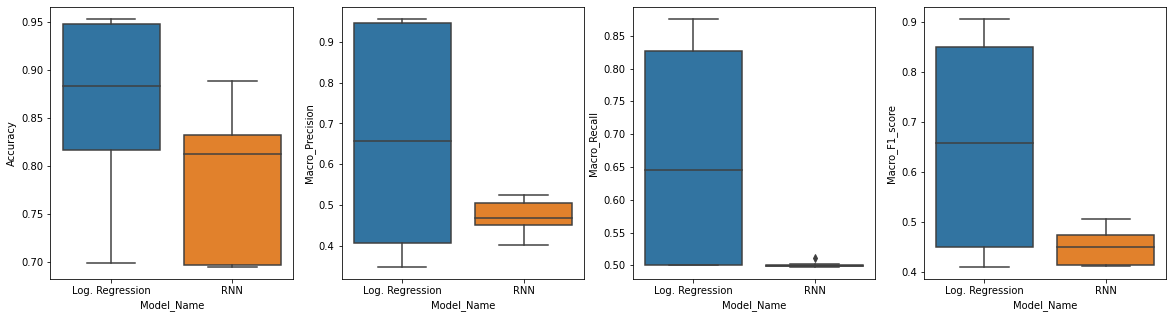

In [51]:
## FIGURE A1 ##

# Boxplot of models

fig, axes = matplot.subplots(1, 4, figsize=(20, 5))

print('Log. Regression vs RNN ')

sns.boxplot(ax=axes[0],x= 'Model_Name', y= 'Accuracy', data = model_perfromance_df)

sns.boxplot(ax=axes[1],x= 'Model_Name', y= 'Macro_Precision', data = model_perfromance_df)

sns.boxplot(ax=axes[2],x= 'Model_Name', y= 'Macro_Recall', data = model_perfromance_df)

sns.boxplot(ax=axes[3],x= 'Model_Name', y= 'Macro_F1_score', data = model_perfromance_df)


##### FIGURE A1 - Ananlysis

Based on the above shown boxplost two main observations can be made. Firstly, Logistic Regression Models varied greatly in their performance while the RNN Models were a lot consisten in their performance. Seconly, the Logistic Regression Models out performed the RNN Models in all cases.



##### FIGURE A2 - ROC for all models

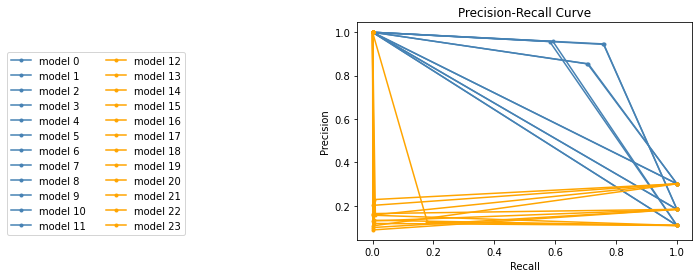

In [52]:
## FIGURE A2 ##

# Precision-Recall Curve of models

# iterate through all keys in prec_recall_dict
for key in list(prec_recall_dict.keys()): 
    
    # plot all logistic regressions in blue
    if key < 12:
        color = 'steelblue'

    # plot all RNN in orange
    else:
        color = 'orange'
    
    # plot the Precision-Recall Curve for each model
    matplot.plot(prec_recall_dict[key][0][1], prec_recall_dict[key][0][0], color=color, marker = '.', label = 'model '+str(key))
    matplot.title('Precision-Recall Curve')
    matplot.ylabel('Precision')
    matplot.xlabel('Recall')
    matplot.legend(loc = 'lower right', bbox_to_anchor=(-0.5,0), ncol = 2)

The models from 0 to 23 are in the following configurations:

In [53]:
model_perfromance_df.iloc[:, 0:3]

,Model_Name,Label,Tokenizer
0,Log. Regression,InfoTheory,vec_01
1,Log. Regression,InfoTheory,vec_02
2,Log. Regression,CompVis,vec_01
3,Log. Regression,CompVis,vec_02
4,Log. Regression,Math,vec_01
5,Log. Regression,Math,vec_02
6,Log. Regression,InfoTheory,vec_01
7,Log. Regression,InfoTheory,vec_02
8,Log. Regression,CompVis,vec_01
9,Log. Regression,CompVis,vec_02


##### FIGURE A2 - Ananlysis

Based on the above shown curve we can see that logistic regressions performed better than the RNNs, moreover the logistic regressions trained on the full data set performed very well, achieving both a high precession and recall.

**Author:**  Armin Berger